Описание проекта:

* Необходимо создать для продуктового менеджера, работающего в студии мобильных игр, функцию расчёта retention.
- Необходимо проанализировать результаты A/B-теста различных промо-наборов для выявления оптимального варианта и определения релевантных показателей принятия решения. 

In [ ]:
from datetime import date, datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import mannwhitneyu, norm, shapiro
from tqdm.auto import tqdm

c:\Users\todur\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Обработка данных

In [3]:
# Считаем данные из файлов
auth_df = pd.read_csv('problem1-auth_data.csv', sep=';')
reg_df = pd.read_csv('problem1-reg_data.csv', sep=';')

In [4]:
# общая информация о датасете 
auth_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


In [5]:
display(f'Размер датасета: {auth_df.shape}')
auth_df.head(3)

'Размер датасета: (9601013, 2)'

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2


In [6]:
# общая информация о датасете 
reg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [7]:
display(f'Размер датасета: {reg_df.shape}')
reg_df.head(3)

'Размер датасета: (1000000, 2)'

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3


In [8]:
# проверим наличие пустых ячеек
auth_df.isna().sum()
reg_df.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [9]:
# проверим число уникальныых id
auth_df.uid.nunique()
reg_df.uid.nunique()

1000000

In [ ]:
# Данные времени представлены в формате timestamp - время в секундах от 1970 года, 
# переведем значения к формату date
auth_df.auth_ts = auth_df.auth_ts.apply(lambda x: datetime.fromtimestamp(x).date())
reg_df.reg_ts = reg_df.reg_ts.apply(lambda x: datetime.fromtimestamp(x).date())

# Переименуем колонки
auth_df.rename(columns={'auth_ts': 'auth_date', 'uid': 'user_id'}, inplace=True)
reg_df.rename(columns={'reg_ts': 'reg_date', 'uid': 'user_id'}, inplace=True)

In [11]:
display(auth_df.head(2))

,auth_date,user_id
0,1998-11-18,1
1,1999-07-23,2


In [12]:
display(reg_df.head(2))

,reg_date,user_id
0,1998-11-18,1
1,1999-07-23,2


# Функция retention

Напишем функцию retention которая на вход получает 4 аргумента:
* дату начала периода когортного анализа в формате yyyy-mm-dd.
* дату окончания периода когортного анализа в формате yyyy-mm-dd.
* retention для какого типа даты необходим (день, неделя, месяц).
* число дней для оценки retention.

In [13]:
def plot_retention_with_custom_scale(auth_df, reg_df):
    # Ввод дополнительных данных
    start_date = input("Введите дату начала периода когортного анализа (yyyy-mm-dd): ")
    end_date = input("Введите дату окончания периода когортного анализа (yyyy-mm-dd): ")
    cohort_type = input("Укажите тип когортного анализа (день, неделя, месяц): ").strip().lower()
    retention_days = int(input("Введите число дней для оценки retention: "))

    # Преобразование колонок с датами
    auth_df['auth_date'] = pd.to_datetime(auth_df['auth_date'])
    reg_df['reg_date'] = pd.to_datetime(reg_df['reg_date'])

    # Фильтрация по заданному диапазону дат
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    reg_df = reg_df[(reg_df['reg_date'] >= start_date) & (reg_df['reg_date'] <= end_date)]

    # Создание когорт
    reg_df['cohort'] = reg_df['reg_date']
    auth_df = auth_df.merge(reg_df[['user_id', 'cohort']], on='user_id', how='inner')

    # Создание периода для когортного анализа
    if cohort_type == "день":
        auth_df['period'] = (auth_df['auth_date'] - auth_df['cohort']).dt.days
    elif cohort_type == "неделя":
        auth_df['period'] = ((auth_df['auth_date'] - auth_df['cohort']).dt.days // 7)
    elif cohort_type == "месяц":
        auth_df['period'] = ((auth_df['auth_date'].dt.to_period('M').astype(int) - 
                             auth_df['cohort'].dt.to_period('M').astype(int)))
    else:
        raise ValueError("Неверный тип когортного анализа!")

    # Расчет retention
    retention = auth_df[auth_df['period'] >= 0].groupby(['cohort', 'period']).user_id.nunique().unstack().fillna(0)
    cohort_sizes = reg_df.groupby('cohort').user_id.nunique()
    retention = retention.div(cohort_sizes, axis=0).iloc[:, :retention_days] * 100

    # Подготовка аннотаций (убрать нули)
    annotations = retention.copy().applymap(lambda x: f"{x:.2f}%" if x > 0 else "")

    # Построение heatmap с изменённой шкалой
    plt.figure(figsize=(16, 8))
    sns.heatmap(
        retention,
        annot=annotations,
        fmt="",
        cmap="coolwarm",  # Изменённая цветовая шкала
        cbar_kws={'label': 'Retention (%)'},
        linewidths=0.5,
        annot_kws={"fontsize": 8},
        vmin=0,  # Минимальное значение шкалы
        vmax=np.percentile(retention.to_numpy(), 95)  # 95-й перцентиль как максимум
    )
    plt.title("Cohorts: User Retention", fontsize=16)
    plt.ylabel("Cohort", fontsize=12)
    plt.xlabel(f"{cohort_type.capitalize()} Period", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.gca().set_yticklabels([date.strftime('%Y-%m-%d') for date in retention.index])
    plt.tight_layout()
    plt.show()

В качестве примера построим график retention. Необходимо ввести следующие данные:
* дату начала периода когортного анализа в формате yyyy-mm-dd: например 2020-09-01
* дату окончания периода когортного анализа в формате yyyy-mm-dd: например 2020-10-01
* retention для какого типа даты необходим (день, неделя, месяц): например день
* Введите число дней для оценки retention: например 30

C:\Users\todur\AppData\Local\Temp\ipykernel_22216\796891515.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_df['cohort'] = reg_df['reg_date']
C:\Users\todur\AppData\Local\Temp\ipykernel_22216\796891515.py:38: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annotations = retention.copy().applymap(lambda x: f"{x:.2f}%" if x > 0 else "")


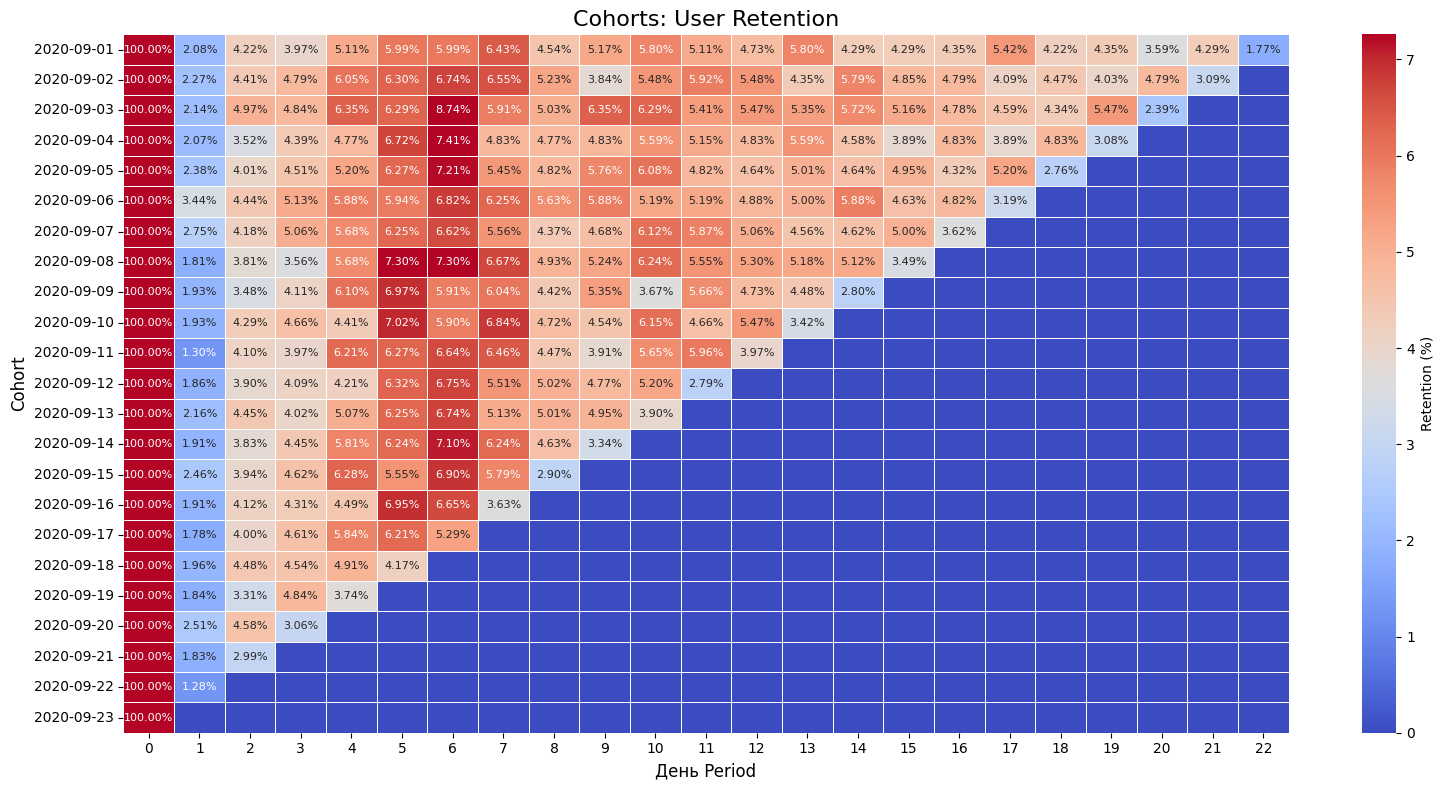

In [43]:
# построим график retention
plot_retention_with_custom_scale(auth_df, reg_df)

Вывод:

График наглядно показывает, что удержание игроков со временем снижается, при этом более свежие когорты (поздние даты) не демонстрируют заметного улучшения метрики. Это свидетельствует о том, что текущая стратегия работы с игроками после их привлечения нуждается в усилении. Дополнительные стимулирующие механики или улучшение игрового опыта на ранних стадиях могут помочь повысить retention на более длительный период.

# А-В тест

In [15]:
# Создадим датафрейм и посмотрим на структуру
df = pd.read_csv('Project_2.csv', sep=';')

df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [16]:
# посмотрим среднее значение для контрольной группы
display(df.query('testgroup == "a"').revenue.mean())

25.413719736965806

In [17]:
# посмотрим среднее значение для тестовой группы
df.query('testgroup == "b"').revenue.mean()

26.75128659327863

In [ ]:
# Посмотрим на распределение revenue по группам пользователей 
# и проверим распределение на нормальность
control_group = df.query('testgroup == "a"').revenue
test_group = df.query('testgroup == "b"').revenue

In [28]:

# тест Шапиро–Уилка на нормальность распределения
display(f"Контрольная группа: {shapiro(control_group.sample(3000))}")

display(f"Тестовая группа: {shapiro(test_group.sample(3000))}")


'Контрольная группа: ShapiroResult(statistic=0.006302177906036377, pvalue=0.0)'

'Тестовая группа: ShapiroResult(statistic=0.060736238956451416, pvalue=0.0)'

p-value в обоих случаях = 0, что значит, что распределения ненормальные, поэтому используем для анализа непараметрический тест Манна-Уитни.

In [ ]:
mannwhitneyu(control_group, test_group)

MannwhitneyuResult(statistic=20491259376.0, pvalue=0.06269701316074398)

p-value > 0.05, поэтому принимаем нулевую гипотезу об одинаковости распределений и делаем вывод, что статистически значимых различий в распеределениях двух групп нет, поэтому различие метрики ARPU нельзя считать значимым.

Теперь проверим группы платящих пользователей

In [ ]:
# доп фильтр по revenue
control_group_p = df.query('testgroup == "a" and revenue != 0').revenue
test_group_p = df.query('testgroup == "b" and revenue != 0').revenue

In [ ]:
# тест на нромальность
shapiro(control_group_p)
shapiro(test_group_p)

ShapiroResult(statistic=0.9583134651184082, pvalue=2.4929213770979496e-22)

распределения также не являются нормальными, проводим тест Манна-Уитни

In [ ]:
mannwhitneyu(control_group_p, test_group_p)

MannwhitneyuResult(statistic=222015.0, pvalue=0.0)

p-value = 0, следовательно отклоняем нулевую гипотезу об одинаковости распределений двух групп и делаем вывод, что данные в группах платящих пользователей различаются статистически значимо.

ARPPU - average rate per paying user, средний чек на платящего пользователя, определим, насколько отличается

In [ ]:
ARPPU_control = control_group_p.mean()
ARPPU_test = test_group_p.mean()
print(f"""Величина ARPPU контрольной группы: {round(ARPPU_control, 2)} руб.,
Величина ARPPU тестовой группы {round(ARPPU_test, 2)} руб, 
Разница в процентах: {"{0:.2%}".format((ARPPU_test - ARPPU_control) / ARPPU_test)}""")

Величина ARPPU контрольной группы: 2664.0 руб.,
Величина ARPPU тестовой группы 3003.66 руб, 
Разница в процентах: 11.31%


Также проведем анализ с помощью бутстрапа для проверки, на каких сегментах платящих пользователей значения статистически значимо отличаются

In [ ]:
# функция для расчета различий по квантилям
def get_bootstrap_quan(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
):
    answer = pd.DataFrame(columns=['quantile', 'p_value', 'first_data_value', 'second_data_value', 'difference'])
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    p_values = {}   
    for elem in np.arange(0.1, 1, 0.1):
        for i in tqdm(range(boot_it)):  # извлекаем подвыборки
            samples_1 = data_column_1.sample(
                boot_len, 
                replace=True  # параметр возвращения
            ).values

            samples_2 = data_column_2.sample(
                boot_len, 
                replace=True
            ).values

            boot_data.append(np.quantile(samples_1, q=elem) - np.quantile(samples_2, q=elem))

        p_1 = norm.cdf(
            x=0, 
            loc=np.mean(boot_data), 
            scale=np.std(boot_data)
        )
        p_2 = norm.cdf(
            x=0, 
            loc=-np.mean(boot_data), 
            scale=np.std(boot_data)
        )
        p_value = min(p_1, p_2) * 2
        elem = "{0:.1f}".format(elem)
        p_values[elem] = p_value
    for quan, p_value in p_values.items():
        first_data_value = data_column_1.quantile(q=float(quan))
        second_data_value = data_column_2.quantile(q=float(quan))
        if p_value < 0.05:
            diff = '{0:.2%}'.format((second_data_value - first_data_value) / second_data_value)
            row = {'quantile': quan, 'p_value': p_value, 
                   'first_data_value': first_data_value,
                   'second_data_value': second_data_value,
                   'difference': diff}
            answer = answer.append(row, ignore_index=True)
        else:
            row = {'quantile': quan, 'p_value': p_value}
            answer = answer.append(row, ignore_index=True) 
    return answer

In [ ]:
get_bootstrap_quan(control_group_p, test_group_p)

   quantile        p_value  first_data_value  second_data_value difference
0       0.1   0.000000e+00             221.0             2202.4     89.97%
1       0.2  2.018696e-105             246.0             2408.0     89.78%
2       0.3   6.380769e-44             267.0             2624.0     89.83%
3       0.4   4.713894e-28             290.0             2810.2     89.68%
4       0.5   1.038004e-19             311.0             3022.0     89.71%
5       0.6   2.851749e-15             333.2             3211.0     89.62%
6       0.7   1.578404e-12             351.9             3404.0     89.66%
7       0.8   7.641350e-11             372.6             3561.6     89.54%
8       0.9   2.632688e-09             393.3             3795.8     89.64%


# Итоги

Итак, в ходе выполнени задания:
* произвели анализ данных в обеих группах на нормальность распределения, с помощью теста Шапиро-Уилка выявили ненормальность распределения в обеих группах.
* так как распределения ненормальные, использовали для сравнения групп непараметрический тест Манна-Уитни (ранговый), получили p-уровень значимости > 0.05, что говорит о невозможности отклонения нулевой гипотезы о равенстве выборок, и, следовательно, о статистически незначимом различии средних значений в данных группах.
* взяли из групп только платящих пользователей и также провели тест на нормальность распределения, который приводит к выводу о ненормальном распределении в обеих группах.
* Для дальнейшего сравнения групп выполнили тест Манна-Уитни и получили p-уровень значимости = 0, следовательно, средние значения в ГС двух выборок не равны и выборки отличаются статистически значимо.
* Определили, что  разница в ARPPU двух групп(средний чек), составляет 11,31%
* с помощью бутстрапа выяснили, на каких децилях распределения revenue различия статистически значимы, получили стат значимые различия на всех децилях распределения в 89%.
* Так как получили, что чеки всех платящих пользователей по децилям в тестовой группе выше чем в контрольной, имеет смысл проверять перед А/Б тестом с помощью А/А тестирования группы пользователей (могут быть различия в сегментах).
* Таким образом, пользователи тестовой группы увеличили свои чеки во всех децилях платящих пользователей, поэтому делаем вывод, что акции в тестовой группе привели к улучшенным показателям метрики ARPPU и данный набор акций можно применять на всех пользователях (выкатывать в продакшн).